In [1]:
# if jupyterlab:
%matplotlib widget
# if jupyter notebook:
# %matplotlib notebook

# Selective and non-selective excitation
import os
import ctypes
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Constants 
gamma       = 267522187.44; # rad/s/T
gamma_hz    = gamma/2/np.pi
FA          = 45 * np.pi/180
ntime       = 400; # number of samples
rf_len      = 4e-3; # second
td          = rf_len/ntime; # dwell-time 
voxel_sz    = np.array([3, 3, 3]) * 1e-3
fov         = np.array([[-60, 45], [-30, 60], [-90, 90]]) * 1e-3
voxel_no    = np.rint((fov[:,1]-fov[:,0]) / voxel_sz).astype(int)
rf_tbw      = 12
is_sinc     = True
is_selective= True


In [2]:
# positions
prx, pry, prz = np.meshgrid(np.linspace(fov[0,0],fov[0,1],voxel_no[0],dtype=np.float32), np.linspace(fov[1,0],fov[1,1],voxel_no[1],dtype=np.float32), np.linspace(fov[2,0],fov[2,1],voxel_no[2],dtype=np.float32), indexing='ij')  
pr      = np.stack((prx, pry, prz), axis=0)
print(pr.shape)

(3, 35, 30, 60)


In [3]:
# off-resonance
b0 = np.zeros(prx.shape, dtype=np.float32, order='F')
m0 = np.zeros((3,)+ prx.shape, dtype=np.float32, order='F')
m0[-1,...] = 1
T1 = np.ones(prx.shape, dtype=np.float32, order='F') * 10000
T2 = np.ones(prx.shape, dtype=np.float32, order='F') * 10000
img = nib.Nifti1Image(np.moveaxis(m0, 0, -1), affine=np.eye(4))
nib.save(img, 'm0.nii')
print(b0.shape)
print(m0.shape)

(35, 30, 60)
(3, 35, 30, 60)


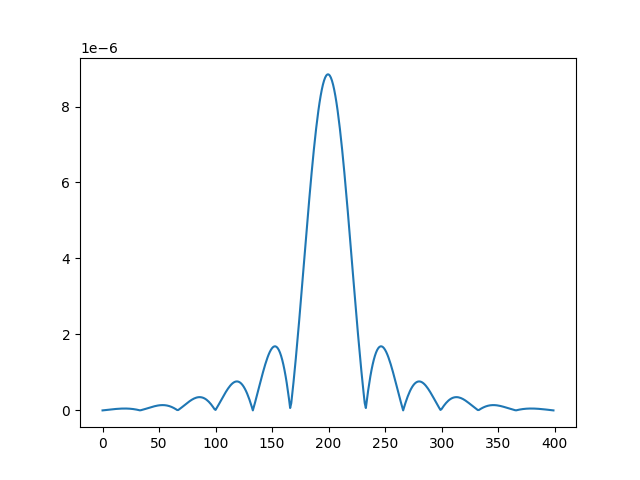

In [4]:
# sinc pulse
b1 = np.ones((ntime, 1), dtype=np.complex64, order='F') * FA/gamma/rf_len; # this is for non-selective
if is_sinc == True :
    t = np.linspace(-rf_len/2, rf_len/2, ntime) # must be column
    BW = rf_tbw/rf_len
    # didn't use 2pi -> we are interested in full BW not only the positive
    snc = np.sinc(t * BW) 
    hamming_window = 0.53836 + 0.46164*np.cos(2*np.pi * np.linspace(-0.5,0.5,ntime))
    rf = snc * hamming_window
    rf = rf / np.sum(rf)# normalize
    b1 = (rf * FA/gamma/td).astype(np.complex64)

# adding RF phase
b1.imag = b1.real # rf phase is 45 degree
b1 = b1 / np.sqrt(2)

_, axs = plt.subplots()
axs.plot(np.abs(b1))


(3, 600)


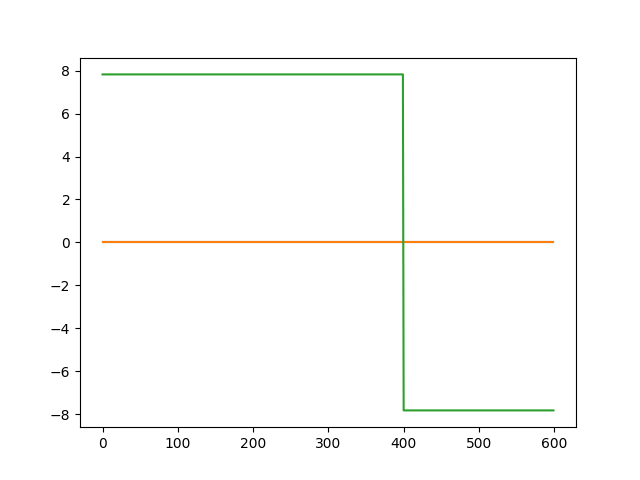

In [5]:
# gradients
gr = np.zeros((3, ntime), dtype=np.float32, order='F')
if is_selective:
    gr = np.zeros((3, ntime + ntime//2), dtype=np.float32, order='F')
    BW = rf_tbw/rf_len; # [Hz]
    g_ss = BW / (3*voxel_sz[2]) / gamma_hz
    gr[2,:ntime] = g_ss  # excitation along Z axis
    gr[2,ntime:] = -g_ss
    b1 = np.append(b1, np.zeros((ntime//2,1), dtype=np.complex64))
    ntime = ntime + ntime//2

print(gr.shape)
_, axs = plt.subplots()
axs.plot(gr[0] * 1e3) # mT/m
axs.plot(gr[1] * 1e3)
axs.plot(gr[2] * 1e3)


In [6]:
%%time
import pyTurboBloch
result = pyTurboBloch.bloch_simulation(b1, gr, pr, b0=b0, td=td, m0=m0)
print(result.shape)
print(np.abs(result[0,...]).max())
print(np.abs(result[1,...]).max())
print(np.min(result[2,...]))


(3, 35, 30, 60)
0.5092147
0.5092147
0.70827156
CPU times: user 2.84 s, sys: 68.6 ms, total: 2.91 s
Wall time: 641 ms


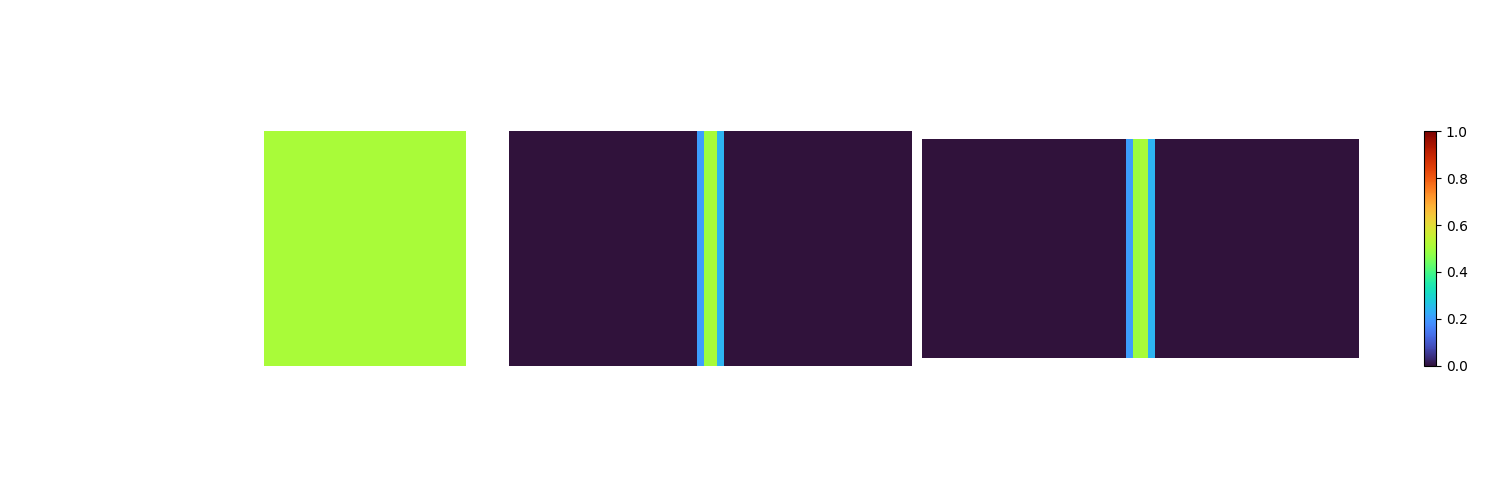

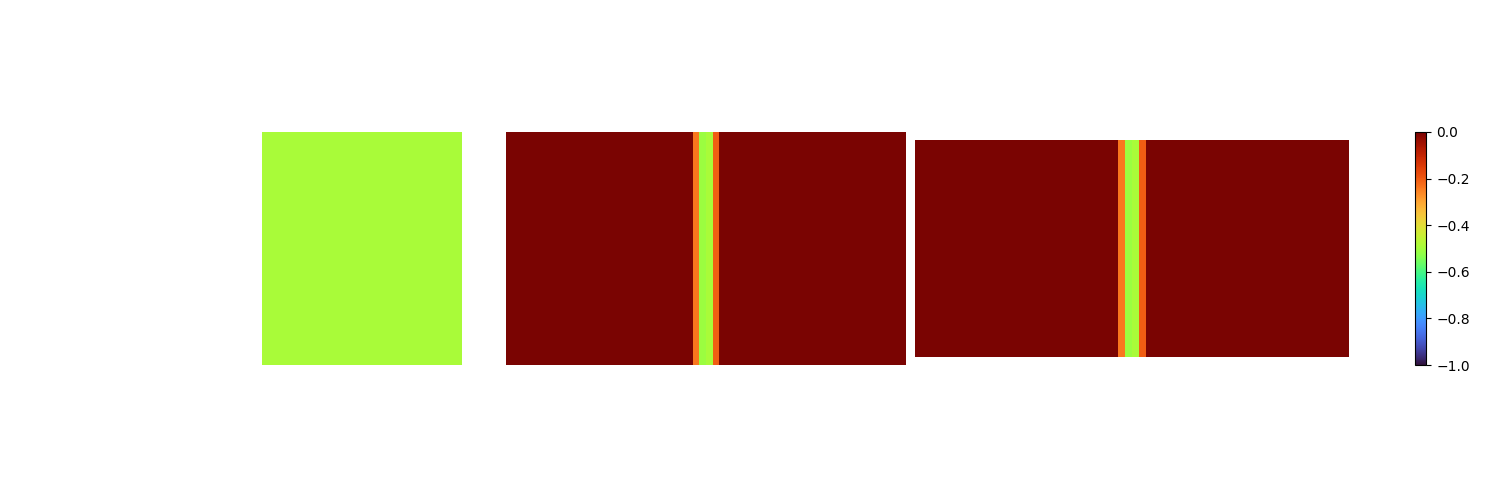

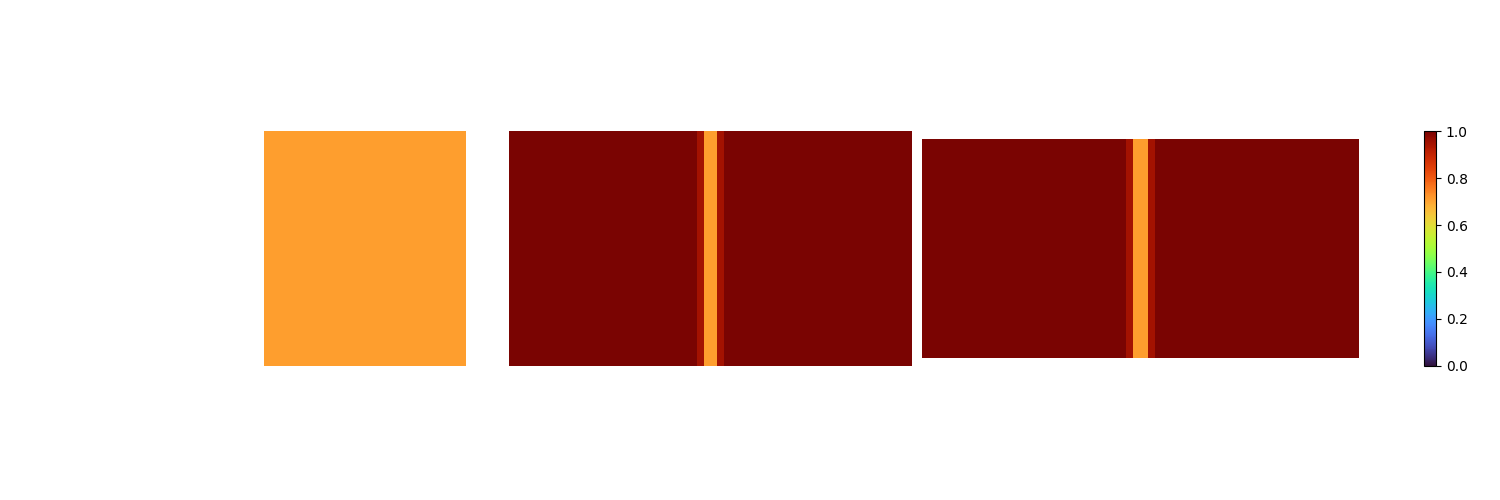

In [7]:
%matplotlib widget
from pytools import plot

plot.plot3D(result[0,...], clim=[0,1])
plot.plot3D(result[1,...], clim=[-1,0])
plot.plot3D(result[2,...], clim=[0,1])